# OLAP Support in SQL

In [ ]:
import pandas as pd
from pandas import DataFrame
from DATA225utils import make_connection, dataframe_query

pd.set_option('display.max_rows', None)

In [ ]:
conn = make_connection(config_file='students.ini')
cursor = conn.cursor()

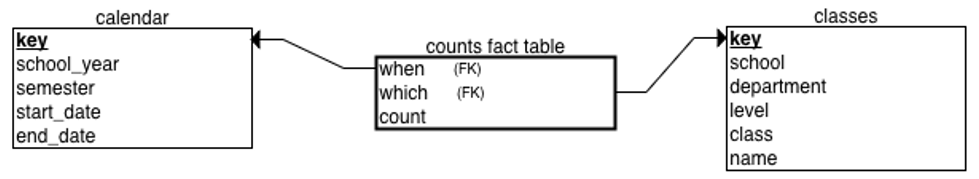

## `calendar` dimension
#### Hierarchy: `school_year`, `semester`

In [ ]:
_, df = dataframe_query(conn, 'SELECT * FROM calendar')
df

## `classes` dimension
#### Hierarchy: `school`, `department`, `level`, `class`

In [ ]:
_, df = dataframe_query(conn, 'SELECT * FROM classes')
df

## `counts` fact table
#### Measure: `count` of students<br>Foreign key to the `calendar` dimension: `when`<br>Foreign key to the `class` dimension: `which`

In [ ]:
_, df = dataframe_query(conn, 'SELECT * FROM counts')
df

## Join the `counts` fact table with the dimension tables

In [ ]:
_, df = dataframe_query(conn, 
    """
    SELECT school_year, semester, YEAR(start_date) AS year, 
           start_date, end_date, 
           school, department, level, class, name, count
    FROM calendar, classes, counts
    WHERE counts.when  = calendar.key
    AND   counts.which = classes.key
    ORDER BY start_date, semester, school, department, level, class
    """
)

df

# Slice: DATA 225 only
#### To slice, hold one attribute of one dimension constant:
``` SQL
classes.class = 'DATA 225'
```

In [ ]:
_, df = dataframe_query(conn, 
    """
    SELECT calendar.*, classes.*, counts.count
    FROM calendar, classes, counts
    WHERE classes.class = 'DATA 225'
    AND   counts.when  = calendar.key
    AND   counts.which = classes.key
    """
)

df

# Slice: Spring semester only
#### To slice, hold one attribute of one dimension constant:
``` SQL
calendar.semester = 'spring'
```

In [ ]:
_, df = dataframe_query(conn, 
    """
    SELECT calendar.*, classes.*, counts.count
    FROM calendar, classes, counts
    WHERE calendar.semester = 'spring'
    AND   counts.when  = calendar.key
    AND   counts.which = classes.key
    """
)

df

# Dice: Graduate students in the schools of Information and Science during fall semesters
#### To dice: Use a range of values in each of one or more dimensions:
``` SQL
WHERE classes.school IN ('Information', 'Science') 
AND   calendar.semester IN ('spring', 'fall')
```

In [ ]:
_, df = dataframe_query(conn, 
    """
    SELECT calendar.*, classes.*, counts.count
    FROM calendar, classes, counts
    WHERE classes.school IN ('Information', 'Science')
    AND   calendar.semester IN ('spring', 'fall')
    AND   classes.level = 'graduate'
    AND   counts.when  = calendar.key
    AND   counts.which = classes.key
    """
)

df

## Drill downs for subtotaling

### Grand total student count

In [ ]:
_, df = dataframe_query(conn, 
    """
    SELECT SUM(count)
    FROM counts
    """
)

df

### Student count subtotals by school year

In [ ]:
_, df = dataframe_query(conn, 
    """
    SELECT school_year,
           SUM(count) AS yearly_total
    FROM calendar, classes, counts
    WHERE counts.when  = calendar.key
    AND   counts.which = classes.key
    GROUP BY school_year
    ORDER BY school_year

    """
)

df

### Student count subtotals by school year and semester

In [ ]:
_, df = dataframe_query(conn, 
    """
    SELECT school_year, semester,
           SUM(count) AS semester_total
    FROM calendar, classes, counts
    WHERE counts.when  = calendar.key
    AND   counts.which = classes.key
    GROUP BY school_year, semester
    ORDER BY school_year, semester

    """
)

df

### Student count subtotals by school year, semester, and school

In [ ]:
_, df = dataframe_query(conn, 
    """
    SELECT school_year, semester, school,
           SUM(count) AS school_total
    FROM calendar, classes, counts
    WHERE counts.when  = calendar.key
    AND   counts.which = classes.key
    GROUP BY school_year, semester, school
    ORDER BY school_year, semester, school

    """
)

df

### Student count subtotals by school year, semester, school, and department

In [ ]:
_, df = dataframe_query(conn, 
    """
    SELECT school_year, semester, school, department,
           SUM(count) AS department_total
    FROM calendar, classes, counts
    WHERE counts.when  = calendar.key
    AND   counts.which = classes.key
    GROUP BY school_year, semester, school, department
    ORDER BY school_year, semester, school, department

    """
)

df

### Student count subtotals by school year, semester, school, department, and level

In [ ]:
_, df = dataframe_query(conn, 
    """
    SELECT school_year, semester, school, department, level,
           SUM(count) AS level_total
    FROM calendar, classes, counts
    WHERE counts.when  = calendar.key
    AND   counts.which = classes.key
    GROUP BY school_year, semester, school, department, level
    ORDER BY school_year, semester, school, department, level

    """
)

df

## Window functions
#### We use window functions to display all the subtotals and the grand total.

In [ ]:
_, df = dataframe_query(conn, 
    """
    SELECT DISTINCT 
        school_year, semester, school, department, level,
        SUM(count) OVER() 
            AS grand_total,
        SUM(count) OVER(PARTITION BY school_year) 
            AS yearly_total,
        SUM(count) OVER(PARTITION BY school_year, semester) 
            AS semester_total,
        SUM(count) OVER(PARTITION BY school_year, semester, school) 
            AS school_total,
        SUM(count) OVER(PARTITION BY school_year, semester, 
                                    school, department) 
            AS dept_total,
        SUM(count) OVER(PARTITION BY school_year, semester, 
                                    school, department, level) 
            AS level_total
    FROM calendar, classes, counts
    WHERE counts.when  = calendar.key
    AND   counts.which = classes.key
    ORDER BY school_year, semester, school, department, level
    """
)

df

In [ ]:
cursor.close()
conn.close()

#### (c) 2023 by Ronald Mak